In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cmocean.cm as cmo
import matplotlib.dates as mdates
from tqdm.notebook import tqdm
from matplotlib.gridspec import GridSpec
import matplotlib.colors as cl
import gsw
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')


ds_bath=xr.open_dataset('/home/jupyter-estelfont/scratch/estel/datasets/bathymetry/gebco_2023_n30.0_s-5.0_w30.0_e80.0.nc')

In [2]:
ds_topaz=xr.open_dataset('/home/jupyter-estelfont/common/fridge/TOPAZ_AS_2000_2020/TOPAZ_AS_2000_2020_z_0_250m.nc')
pressure_broadcasted = np.transpose(np.broadcast_to(ds_topaz.pressure, (2541, 120, 181, 27)), (0, 3, 1, 2))
ds_topaz['pressure_grid']=(('time', 'pressure', 'latitude', 'longitude'), pressure_broadcasted)
# 
ds_topaz_n2_mld=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_topaz/tropaz_n2_mld.nc')
ds_topaz_mwd=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_topaz/tropaz_mwl.nc')

ds_topaz=xr.merge([ds_topaz, ds_topaz_n2_mld, ds_topaz_mwd])
ds_topaz['mw_thickness']=ds_topaz.bot_mwl-ds_topaz.bot_mwl

del ds_topaz_n2_mld, ds_topaz_mwd

In [3]:
# ds_topaz

In [4]:
# ds_topaz['o2_sol']=gsw.O2sol(ds_topaz.abs_salinity, ds_topaz.cons_temp, ds_topaz.pressure, ds_topaz.longitude, ds_topaz.latitude)
# ds_topaz['aou']=ds_topaz['o2_sol']-ds_topaz['oxygen_concentration']

In [5]:
dff_presence_1_topaz = ds_topaz.presence_mwl.where(ds_topaz.presence_mwl != 0, np.nan)
dff_presence_1_topaz = dff_presence_1_topaz.where(ds_topaz.presence_mwl != 2, np.nan)

## only duration
dff_presence_2_topaz = ds_topaz.presence_mwl.where(ds_topaz.presence_mwl != 0, np.nan)
dff_presence_2_topaz = dff_presence_2_topaz.where(ds_topaz.presence_mwl != 1, np.nan)
dff_presence_2_topaz = dff_presence_2_topaz.where(ds_topaz.presence_mwl !=2, 1)

# no mode water
dff_presence_0_topaz = ds_topaz.presence_mwl.where(ds_topaz.presence_mwl != 1, np.nan)
dff_presence_0_topaz = dff_presence_0_topaz.where(ds_topaz.presence_mwl != 2, np.nan)
dff_presence_0_topaz = dff_presence_0_topaz.where(ds_topaz.presence_mwl !=0, 1)

mskk_topaz=np.nansum([dff_presence_1_topaz, dff_presence_0_topaz], axis=0)
mskk_topaz[mskk_topaz==0]=np.nan
ds_topaz['msk_presence']=(('latitude', 'longitude','time'), mskk_topaz)

# ds_topaz_week_tmwl_msk_group=(ds_topaz.top_mwl*mskk_topaz).groupby('time.week')
# ds_topaz_week_bmwl_msk_group=(ds_topaz.bot_mwl*mskk_topaz).groupby('time.week')

# ds_topaz_week_tmwl_group=(ds_topaz.top_mwl).groupby('time.week')
# ds_topaz_week_tmwl_group=(ds_topaz.top_mwl).groupby('time.week')

In [6]:
# Assuming 'data' is your xarray DataArray with 'latitude' and 'longitude' coordinates
R = 6371e3  # Earth radius in meters

# Convert latitude and longitude from degrees to radians
latitude_rad = np.deg2rad(ds_topaz['latitude'])
longitude_rad = np.deg2rad(ds_topaz['longitude'])

dlat = np.abs(np.diff(latitude_rad))
dlon = np.abs(np.diff(longitude_rad))

# For latitudes and longitudes differences, pad the arrays to match the dimensions of latitude and longitude
dlat = np.append(dlat, dlat[-1])  # Add an extra element to match the latitude array size
dlon = np.append(dlon, dlon[-1])  # Add an extra element to match the longitude array size

# Create 2D arrays for latitude and longitude differences
dlat_2d, dlon_2d = np.meshgrid(dlat, dlon, indexing='ij')

# Calculate the area of each grid cell
cell_area = (R**2 * dlat_2d * dlon_2d * np.cos(latitude_rad).values[:, np.newaxis])

# Adjust the dimensions if needed to match the data dimensions
cell_area = xr.DataArray(cell_area, dims=['latitude', 'longitude'], coords=[ds_topaz.latitude, ds_topaz.longitude])

## OXYGEN CONTENT

In [8]:
## MASK O2 in SML
mld_broadcasted = (ds_topaz.mixed_layer_depth).expand_dims(pressure=ds_topaz.pressure, axis=2)
masked_oxy_sml = ds_topaz.oxygen_concentration.where((ds_topaz.pressure <= mld_broadcasted))

masked_oxy_0_sml=masked_oxy_sml.fillna(0)
_integrate_o2_sml=masked_oxy_0_sml.integrate('pressure')

del masked_oxy_sml, masked_oxy_0_sml

In [ ]:
# _integrate_o2_sml

In [9]:
## MASK O2 in MWL
top_broadcasted = (ds_topaz.top_mwl*ds_topaz.msk_presence).expand_dims(pressure=ds_topaz.pressure, axis=2)
bot_broadcasted = (ds_topaz.bot_mwl*ds_topaz.msk_presence).expand_dims(pressure=ds_topaz.pressure, axis=2)
masked_oxy = ds_topaz.oxygen_concentration.where((ds_topaz.pressure >= top_broadcasted) & (ds_topaz.pressure <= bot_broadcasted))

masked_oxy_0=masked_oxy.fillna(0)
_integrate_o2=masked_oxy_0.integrate('pressure')

del masked_oxy, masked_oxy_0

In [10]:
## integrate all o2 contetnt
ds_topaz['o2_fill']=ds_topaz.oxygen_concentration.fillna(0)
o2_topaz_integ=ds_topaz.o2_fill.integrate('pressure')

## plot

In [11]:
# Multiply the variable by the cell area to weight by area
def integrate_lat_lon(ds):
    weighted_data = ds * cell_area
    integrated_value_heat = weighted_data.sum(dim=['latitude', 'longitude'])
    return integrated_value_heat

In [ ]:
## % contribution annually to all upper o2 content
print('% contribution annually to upper o2 content:')

print('AS:')
print((integrate_lat_lon(_integrate_o2).groupby('time.year').sum()*100/integrate_lat_lon(o2_topaz_integ).groupby('time.year').sum()).mean().values)
print((integrate_lat_lon(_integrate_o2).groupby('time.year').sum()*100/integrate_lat_lon(o2_topaz_integ).groupby('time.year').sum()).std().values)

print(' NAS:')
print((integrate_lat_lon(_integrate_o2.where(_integrate_o2.latitude>20, drop=True)).groupby('time.year').sum()*100/integrate_lat_lon(o2_topaz_integ.where(o2_topaz_integ.latitude>20, drop=True)).groupby('time.year').sum()).mean().values)
print((integrate_lat_lon(_integrate_o2.where(_integrate_o2.latitude>20, drop=True)).groupby('time.year').sum()*100/integrate_lat_lon(o2_topaz_integ.where(o2_topaz_integ.latitude>20, drop=True)).groupby('time.year').sum()).std().values)
print(' SAS:')
print((integrate_lat_lon(_integrate_o2.where(_integrate_o2.latitude<20, drop=True)).groupby('time.year').sum()*100/integrate_lat_lon(o2_topaz_integ.where(o2_topaz_integ.latitude<20, drop=True)).groupby('time.year').sum()).mean().values)
print((integrate_lat_lon(_integrate_o2.where(_integrate_o2.latitude<20, drop=True)).groupby('time.year').sum()*100/integrate_lat_lon(o2_topaz_integ.where(o2_topaz_integ.latitude<20, drop=True)).groupby('time.year').sum()).std().values)

In [ ]:
## % contribution annually to all upper o2 content
print('% contribution annually to upper o2 content:')

print('AS:')
print((integrate_lat_lon(_integrate_o2).groupby('time.year').sum()*100/integrate_lat_lon(_integrate_o2_sml).groupby('time.year').sum()).mean().values)
print((integrate_lat_lon(_integrate_o2).groupby('time.year').sum()*100/integrate_lat_lon(_integrate_o2_sml).groupby('time.year').sum()).std().values)

print(' NAS:')
print((integrate_lat_lon(_integrate_o2.where(_integrate_o2.latitude>20, drop=True)).groupby('time.year').sum()*100/integrate_lat_lon(_integrate_o2_sml.where(_integrate_o2_sml.latitude>20, drop=True)).groupby('time.year').sum()).mean().values)
print((integrate_lat_lon(_integrate_o2.where(_integrate_o2.latitude>20, drop=True)).groupby('time.year').sum()*100/integrate_lat_lon(_integrate_o2_sml.where(_integrate_o2_sml.latitude>20, drop=True)).groupby('time.year').sum()).std().values)
print(' SAS:')
print((integrate_lat_lon(_integrate_o2.where(_integrate_o2.latitude<20, drop=True)).groupby('time.year').sum()*100/integrate_lat_lon(_integrate_o2_sml.where(_integrate_o2_sml.latitude<20, drop=True)).groupby('time.year').sum()).mean().values)
print((integrate_lat_lon(_integrate_o2.where(_integrate_o2.latitude<20, drop=True)).groupby('time.year').sum()*100/integrate_lat_lon(_integrate_o2_sml.where(_integrate_o2_sml.latitude<20, drop=True)).groupby('time.year').sum()).std().values)

In [108]:
# ## % contribution annually to all upper o2 content
# print('std contribution season to upper oxy content:')

# sea_=['DJF', 'MAM', 'JJA', 'SON']
# print('AS:')
# for i in sea_:
#     print(i)
#     print((integrate_lat_lon(_integrate_o2).groupby('time.season')[i]*100/integrate_lat_lon(_integrate_o2_sml).groupby('time.season')[i]).std().values)
# print(' NAS:')
# for i in sea_:
#     print(i)
#     print((integrate_lat_lon(_integrate_o2.where(_integrate_o2.latitude>20, drop=True)).groupby('time.season')[i]*100/integrate_lat_lon(_integrate_o2_sml.where(_integrate_o2_sml.latitude>20, drop=True)).groupby('time.season')[i]).std().values)
# print(' SAS:')
# for i in sea_:
#     print(i)
#     print((integrate_lat_lon(_integrate_o2.where(_integrate_o2.latitude<20, drop=True)).groupby('time.season')[i]*100/integrate_lat_lon(_integrate_o2_sml.where(_integrate_o2_sml.latitude<20, drop=True)).groupby('time.season')[i]).std().values)


In [107]:
## % contribution annually to all upper o2 content
print('% contribution season to upper oxy content:')

sea_=['DJF', 'MAM', 'JJA', 'SON']
print('AS:')
for i in sea_:
    print(i)
    print((integrate_lat_lon(_integrate_o2).groupby('time.season')[i]*100/integrate_lat_lon(o2_topaz_integ).groupby('time.season')[i]).mean().values, ' ', (integrate_lat_lon(_integrate_o2).groupby('time.season')[i]*100/integrate_lat_lon(o2_topaz_integ).groupby('time.season')[i]).std().values)
print(' NAS:')
for i in sea_:
    print(i)
    print((integrate_lat_lon(_integrate_o2.where(_integrate_o2.latitude>20, drop=True)).groupby('time.season')[i]*100/integrate_lat_lon(o2_topaz_integ.where(o2_topaz_integ.latitude>20, drop=True)).groupby('time.season')[i]).mean().values, ' ',
     (integrate_lat_lon(_integrate_o2.where(_integrate_o2.latitude>20, drop=True)).groupby('time.season')[i]*100/integrate_lat_lon(o2_topaz_integ.where(o2_topaz_integ.latitude>20, drop=True)).groupby('time.season')[i]).std().values)
          
print(' SAS:')
for i in sea_:
    print(i)
    print((integrate_lat_lon(_integrate_o2.where(_integrate_o2.latitude<20, drop=True)).groupby('time.season')[i]*100/integrate_lat_lon(o2_topaz_integ.where(o2_topaz_integ.latitude<20, drop=True)).groupby('time.season')[i]).mean().values, ' ',
     (integrate_lat_lon(_integrate_o2.where(_integrate_o2.latitude<20, drop=True)).groupby('time.season')[i]*100/integrate_lat_lon(o2_topaz_integ.where(o2_topaz_integ.latitude<20, drop=True)).groupby('time.season')[i]).std().values)
          


% contribution season to upper oxy content:
AS:
DJF
2.6385041545207732   4.1087959997682955
MAM
7.412720950847542   4.473333665917775
JJA
1.603655631132688   1.15271821403091
SON
3.5954539076802763   2.589602827831748
 NAS:
DJF
3.460392392962876   8.239324503021578
MAM
20.870786633667002   8.89366939200096
JJA
5.651762357621774   3.3777731933130264
SON
1.103124251814317   1.2094190918043866
 SAS:
DJF
2.5210158362021655   3.698865512482907
MAM
5.593025382466397   4.017509054232684
JJA
1.091837860967484   1.2964556746637903
SON
3.8963890259899774   2.854903213737497


In [109]:
## % contribution annually to all upper o2 content
print('% contribution season to upper oxy content:')

sea_=['DJF', 'MAM', 'JJA', 'SON']
print('AS:')
for i in sea_:
    print(i)
    print((integrate_lat_lon(_integrate_o2).groupby('time.season')[i]*100/integrate_lat_lon(_integrate_o2_sml).groupby('time.season')[i]).mean().values, ' ', 
    (integrate_lat_lon(_integrate_o2).groupby('time.season')[i]*100/integrate_lat_lon(_integrate_o2_sml).groupby('time.season')[i]).std().values)
print(' NAS:')
for i in sea_:
    print(i)
    print((integrate_lat_lon(_integrate_o2.where(_integrate_o2.latitude>20, drop=True)).groupby('time.season')[i]*100/integrate_lat_lon(_integrate_o2_sml.where(_integrate_o2_sml.latitude>20, drop=True)).groupby('time.season')[i]).mean().values, ' ', 
      (integrate_lat_lon(_integrate_o2.where(_integrate_o2.latitude>20, drop=True)).groupby('time.season')[i]*100/integrate_lat_lon(_integrate_o2_sml.where(_integrate_o2_sml.latitude>20, drop=True)).groupby('time.season')[i]).std().values)
         
print(' SAS:')
for i in sea_:
    print(i)
    print((integrate_lat_lon(_integrate_o2.where(_integrate_o2.latitude<20, drop=True)).groupby('time.season')[i]*100/integrate_lat_lon(_integrate_o2_sml.where(_integrate_o2_sml.latitude<20, drop=True)).groupby('time.season')[i]).mean().values, ' ', 
     (integrate_lat_lon(_integrate_o2.where(_integrate_o2.latitude<20, drop=True)).groupby('time.season')[i]*100/integrate_lat_lon(_integrate_o2_sml.where(_integrate_o2_sml.latitude<20, drop=True)).groupby('time.season')[i]).std().values)


% contribution season to upper oxy content:
AS:
DJF
7.642206523169359   14.11721202987648
MAM
34.78372549414858   19.60111190290662
JJA
4.649203925774183   3.837361333923944
SON
13.455574878938375   10.409828391752745
 NAS:
DJF
9.735377098544696   28.138303904134354
MAM
109.14545394582771   43.989997978248894
JJA
32.45668724045123   22.93578804416195
SON
4.595834429342298   5.582417923360862
 SAS:
DJF
7.528683977889214   13.066926285508046
MAM
25.980305259840183   17.54114734434256
JJA
2.965588650753307   3.8100549216227986
SON
14.528164178561818   11.43243777794508


AS:


(0.0, 25.0)

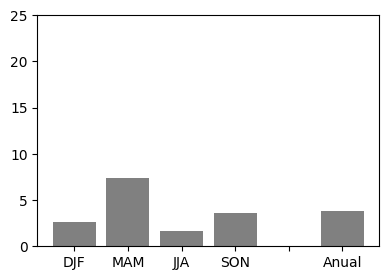

In [12]:
sea_=['DJF', 'MAM', 'JJA', 'SON', ' ', 'Anual']

cn, cs=["#a60021",
"#81a35e"]

plt.figure(figsize=(15,3))
plt.subplot(131)
contrib_AS=[]
contrib_AS_std=[]
print('AS:')
for i in sea_[:4]:
    # print(i)
    contrib_AS.append((integrate_lat_lon(_integrate_o2).groupby('time.season')[i]*100/integrate_lat_lon(o2_topaz_integ).groupby('time.season')[i]).mean().values)
    contrib_AS_std.append((integrate_lat_lon(_integrate_o2).groupby('time.season')[i]*100/integrate_lat_lon(o2_topaz_integ).groupby('time.season')[i]).std().values)
contrib_AS.append(np.array(0))
contrib_AS_std.append(np.array(0))

contrib_AS.append((integrate_lat_lon(_integrate_o2).groupby('time.year').sum()*100/integrate_lat_lon(o2_topaz_integ).groupby('time.year').sum()).mean().values)
contrib_AS_std.append((integrate_lat_lon(_integrate_o2).groupby('time.year').sum()*100/integrate_lat_lon(o2_topaz_integ).groupby('time.year').sum()).std().values)

plt.bar(sea_, contrib_AS, color='gray')
plt.ylim(0,25)


In [105]:
# sea_=['DJF', 'MAM', 'JJA', 'SON', ' ', 'Anual']

# cn, cs=["#a60021",
# "#81a35e"]

# plt.figure(figsize=(15,3))
# plt.subplot(131)
# contrib_AS=[]
# contrib_AS_std=[]
# print('AS:')
# for i in sea_[:4]:
#     # print(i)
#     contrib_AS.append((integrate_lat_lon(_integrate_o2).groupby('time.season')[i]*100/integrate_lat_lon(_integrate_o2_sml).groupby('time.season')[i]).mean().values)
#     contrib_AS_std.append((integrate_lat_lon(_integrate_o2).groupby('time.season')[i]*100/integrate_lat_lon(_integrate_o2_sml).groupby('time.season')[i]).std().values)
# contrib_AS.append(np.array(0))
# contrib_AS_std.append(np.array(0))

# contrib_AS.append((integrate_lat_lon(_integrate_o2).groupby('time.year').sum()*100/integrate_lat_lon(_integrate_o2_sml).groupby('time.year').sum()).mean().values)
# contrib_AS_std.append((integrate_lat_lon(_integrate_o2).groupby('time.year').sum()*100/integrate_lat_lon(_integrate_o2_sml).groupby('time.year').sum()).std().values)

# plt.bar(sea_, contrib_AS, color='gray')
# plt.ylim(0,100)


 NAS:


(0.0, 25.0)

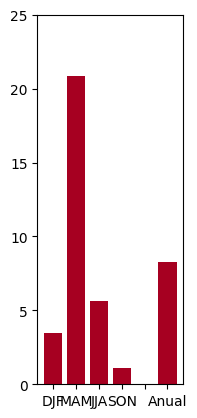

In [13]:
plt.subplot(132)
contrib_nas=[]
contrib_nas_std=[]

print(' NAS:')
for i in sea_[:4]:
    # print(i)
    contrib_nas.append((integrate_lat_lon(_integrate_o2.where(_integrate_o2.latitude>20, drop=True)).groupby('time.season')[i]*100/integrate_lat_lon(o2_topaz_integ.where(o2_topaz_integ.latitude>20, drop=True)).groupby('time.season')[i]).mean().values)
    contrib_nas_std.append((integrate_lat_lon(_integrate_o2.where(_integrate_o2.latitude>20, drop=True)).groupby('time.season')[i]*100/integrate_lat_lon(o2_topaz_integ.where(o2_topaz_integ.latitude>20, drop=True)).groupby('time.season')[i]).std().values)

contrib_nas.append(np.array(0))
contrib_nas_std.append(np.array(0))

contrib_nas.append((integrate_lat_lon(_integrate_o2.where(_integrate_o2.latitude>20, drop=True)).groupby('time.year').sum()*100/integrate_lat_lon(o2_topaz_integ.where(o2_topaz_integ.latitude>20, drop=True)).groupby('time.year').sum()).mean().values)
contrib_nas_std.append((integrate_lat_lon(_integrate_o2.where(_integrate_o2.latitude>20, drop=True)).groupby('time.year').sum()*100/integrate_lat_lon(o2_topaz_integ.where(o2_topaz_integ.latitude>20, drop=True)).groupby('time.year').sum()).std().values)

plt.bar(sea_, contrib_nas, color=cn)
plt.ylim(0,25)

In [106]:
# plt.subplot(132)
# contrib_nas=[]
# contrib_nas_std=[]

# print(' NAS:')
# for i in sea_[:4]:
#     # print(i)
#     contrib_nas.append((integrate_lat_lon(_integrate_o2.where(_integrate_o2.latitude>20, drop=True)).groupby('time.season')[i]*100/integrate_lat_lon(_integrate_o2_sml.where(_integrate_o2_sml.latitude>20, drop=True)).groupby('time.season')[i]).mean().values)
#     contrib_nas_std.append((integrate_lat_lon(_integrate_o2.where(_integrate_o2.latitude>20, drop=True)).groupby('time.season')[i]*100/integrate_lat_lon(_integrate_o2_sml.where(_integrate_o2_sml.latitude>20, drop=True)).groupby('time.season')[i]).std().values)

# contrib_nas.append(np.array(0))
# contrib_nas_std.append(np.array(0))

# contrib_nas.append((integrate_lat_lon(_integrate_o2.where(_integrate_o2.latitude>20, drop=True)).groupby('time.year').sum()*100/integrate_lat_lon(_integrate_o2_sml.where(_integrate_o2_sml.latitude>20, drop=True)).groupby('time.year').sum()).mean().values)
# contrib_nas_std.append((integrate_lat_lon(_integrate_o2.where(_integrate_o2.latitude>20, drop=True)).groupby('time.year').sum()*100/integrate_lat_lon(_integrate_o2_sml.where(_integrate_o2_sml.latitude>20, drop=True)).groupby('time.year').sum()).std().values)

# plt.bar(sea_, contrib_nas, color=cn)
# plt.ylim(0,50)

In [91]:
contrib_nas_std

[array(28.1383039),
 array(43.98999798),
 array(22.93578804),
 array(5.58241792),
 array(0),
 array(5.78706789)]

 SAS:


(0.0, 25.0)

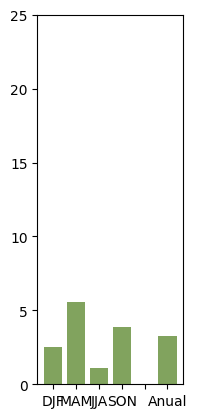

In [14]:

plt.subplot(133)
contrib_sas=[]
contrib_sas_std=[]

print(' SAS:')
for i in sea_[:4]:
    # print(i)
    contrib_sas.append((integrate_lat_lon(_integrate_o2.where(_integrate_o2.latitude<20, drop=True)).groupby('time.season')[i]*100/integrate_lat_lon(o2_topaz_integ.where(o2_topaz_integ.latitude<20, drop=True)).groupby('time.season')[i]).mean().values)
    contrib_sas_std.append((integrate_lat_lon(_integrate_o2.where(_integrate_o2.latitude<20, drop=True)).groupby('time.season')[i]*100/integrate_lat_lon(o2_topaz_integ.where(o2_topaz_integ.latitude<20, drop=True)).groupby('time.season')[i]).std().values)

contrib_sas.append(np.array(0))
contrib_sas_std.append(np.array(0))

contrib_sas.append((integrate_lat_lon(_integrate_o2.where(_integrate_o2.latitude<20, drop=True)).groupby('time.year').sum()*100/integrate_lat_lon(o2_topaz_integ.where(o2_topaz_integ.latitude<20, drop=True)).groupby('time.year').sum()).mean().values)
contrib_sas_std.append((integrate_lat_lon(_integrate_o2.where(_integrate_o2.latitude<20, drop=True)).groupby('time.year').sum()*100/integrate_lat_lon(o2_topaz_integ.where(o2_topaz_integ.latitude<20, drop=True)).groupby('time.year').sum()).std().values)

plt.bar(sea_, contrib_sas, color=cs)
plt.ylim(0,25)

 SAS:


(0.0, 100.0)

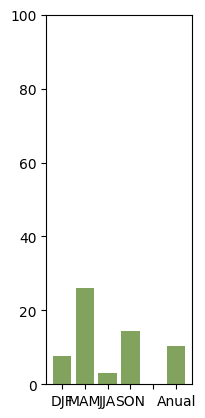

In [92]:

# plt.subplot(133)
# contrib_sas=[]
# contrib_sas_std=[]

# print(' SAS:')
# for i in sea_[:4]:
#     # print(i)
#     contrib_sas.append((integrate_lat_lon(_integrate_o2.where(_integrate_o2.latitude<20, drop=True)).groupby('time.season')[i]*100/integrate_lat_lon(_integrate_o2_sml.where(_integrate_o2_sml.latitude<20, drop=True)).groupby('time.season')[i]).mean().values)
#     contrib_sas_std.append((integrate_lat_lon(_integrate_o2.where(_integrate_o2.latitude<20, drop=True)).groupby('time.season')[i]*100/integrate_lat_lon(_integrate_o2_sml.where(_integrate_o2_sml.latitude<20, drop=True)).groupby('time.season')[i]).std().values)

# contrib_sas.append(np.array(0))
# contrib_sas_std.append(np.array(0))

# contrib_sas.append((integrate_lat_lon(_integrate_o2.where(_integrate_o2.latitude<20, drop=True)).groupby('time.year').sum()*100/integrate_lat_lon(_integrate_o2_sml.where(_integrate_o2_sml.latitude<20, drop=True)).groupby('time.year').sum()).mean().values)
# contrib_sas_std.append((integrate_lat_lon(_integrate_o2.where(_integrate_o2.latitude<20, drop=True)).groupby('time.year').sum()*100/integrate_lat_lon(_integrate_o2_sml.where(_integrate_o2_sml.latitude<20, drop=True)).groupby('time.year').sum()).std().values)

# plt.bar(sea_, contrib_sas, color=cs)
# plt.ylim(0,100)

In [93]:
contrib_sas_std

[array(13.06692629),
 array(17.54114734),
 array(3.81005492),
 array(11.43243778),
 array(0),
 array(1.29214581)]

In [136]:
all_ = integrate_lat_lon(o2_topaz_integ).groupby('time.week').mean()
all_s = integrate_lat_lon(o2_topaz_integ).groupby('time.week').std()
mw_=integrate_lat_lon(_integrate_o2).groupby('time.week').mean()
mw_s=integrate_lat_lon(_integrate_o2).groupby('time.week').std()

In [140]:
all_=integrate_lat_lon(_integrate_o2_sml.where(_integrate_o2_sml.latitude>20, drop=True)).groupby('time.week').mean()
mw_=integrate_lat_lon(_integrate_o2.where(_integrate_o2_sml.latitude>20, drop=True)).groupby('time.week').mean()
mw_s=integrate_lat_lon(_integrate_o2.where(_integrate_o2_sml.latitude>20, drop=True)).groupby('time.week').std()


In [142]:
# mw_.max()*1e-18, mw_s.max()*1e-18

(mw_ * 100 / all_)[:], (mw_s * 100 / all_)[:]

(<xarray.DataArray (week: 53)>
 array([  0.34015617,   0.46639405,   0.73861701,   1.11059937,
          2.61107908,   5.76533755,   9.15578913,  36.61511799,
         67.30344115,  84.74826967,  98.14728138, 128.3352192 ,
        129.55613385, 125.96185151, 124.57298142, 116.04909575,
        106.65158114, 101.80156983,  93.83518082,  83.37925807,
         74.36022395,  66.82863017,  58.72334169,  53.05944353,
         47.14190459,  41.72036042,  36.48130016,  32.04823587,
         27.24376703,  23.04718743,  20.12428813,  17.17856348,
         14.69918562,  13.41153324,  11.26687352,   9.33996591,
          8.74415654,   7.23909141,   5.8216156 ,   5.62142423,
          4.63401634,   3.69306906,   3.44959246,   2.6720971 ,
          1.99050674,   1.8471227 ,   1.36013139,   1.02332132,
          1.0222283 ,   0.75979924,   0.60327695,   0.63698835,
          0.27686288])
 Coordinates:
   * week     (week) int64 1 2 3 4 5 6 7 8 9 10 ... 44 45 46 47 48 49 50 51 52 53,
 <xarray.DataArra

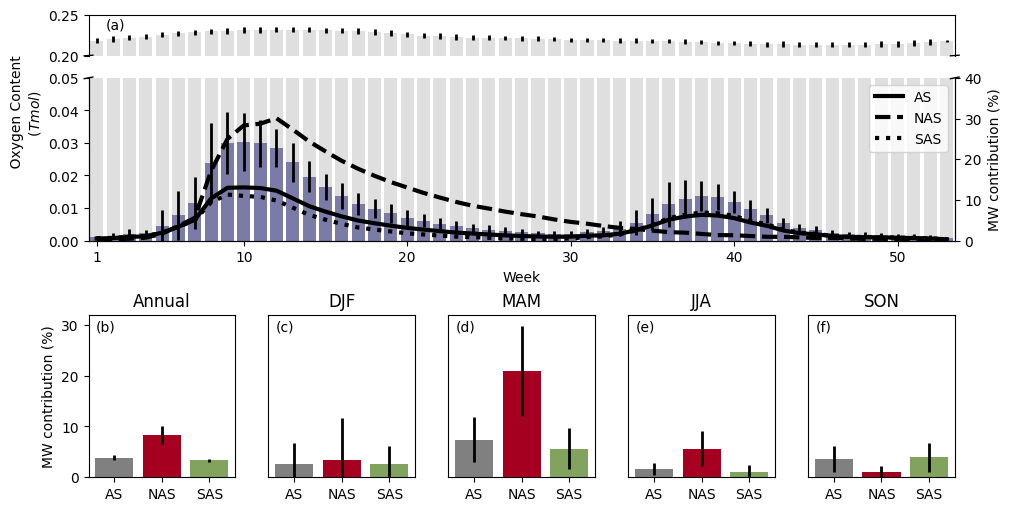

In [16]:
fig=plt.figure(figsize=(10,5), constrained_layout=True)

xx,yy=9,5

gs = GridSpec(xx,yy, figure=fig)

ax1 = fig.add_subplot(gs[0, :])
plt.xticks([])
ax2 = fig.add_subplot(gs[1:5, :])
t=ax1.text(x=.02,y=.65,s="(a)",transform=ax1.transAxes, zorder=120)
## OXY
# Calculate the mean and standard deviation grouped by the week of the year
all_ = integrate_lat_lon(o2_topaz_integ).groupby('time.week').mean()
all_s = integrate_lat_lon(o2_topaz_integ).groupby('time.week').std()
mw_=integrate_lat_lon(_integrate_o2).groupby('time.week').mean()
mw_s=integrate_lat_lon(_integrate_o2).groupby('time.week').std()

SF=1e-18

# Plot on the first axis (0 to 1e17)
ax1.bar(mw_.week, all_*SF, color='silver', alpha=0.5)
ax1.bar(mw_.week, mw_*SF, color='midnightblue', alpha=0.5)
ax1.errorbar(mw_.week, all_*SF, yerr=all_s*SF,  elinewidth=2, lw=0, color='k')
ax1.errorbar(mw_.week, mw_*SF, yerr=mw_s*SF, elinewidth=2, lw=0, color='k')
ax1.set_ylim(0.2, 0.25)
# ax1.set_xticks([])
ax1.spines['bottom'].set_visible(False)
# ax1.tick_params(labeltop=False)  # Don't put tick labels at the top axis
# 
# Plot on the second axis (1e17 to 2.5e17)
ax2.bar(mw_.week, all_*SF, color='silver', alpha=0.5)
ax2.bar(mw_.week, mw_*SF, color='midnightblue', alpha=0.5)
ax2.errorbar(mw_.week, all_*SF, yerr=all_s*SF,  elinewidth=2, lw=0, color='k')
ax2.errorbar(mw_.week, mw_*SF, yerr=mw_s*SF, elinewidth=2, lw=0, color='k')
ax2.set_ylim(0, 0.05)

# Hide the spines and create a break in the y-axis
ax2.spines['top'].set_visible(False)
ax1.tick_params(labeltop=False, bottom=False)
ax1.set_xlim(0.5, 53.5) 

ax2.set_xticks([1,10,20,30,40,50])
# ax2.xaxis.tick_bottom()

# Diagonal lines to indicate the break in the y-axis
d = .005  # Size of the diagonal lines
kwargs = dict(transform=ax1.transAxes, color='k', lw=1, clip_on=False)
ax1.plot((-d, +d), (-d*1.5, +d*1.5), **kwargs)
ax1.plot((1 - d, 1 + d), (-d*1.5, +d*1.5), **kwargs) 

kwargs.update(transform=ax2.transAxes)  # Switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

# Set labels and limits
ax2.set_ylabel('                       Oxygen Content \n                     ($Tmol$)')
ax2.set_xlim(0.5, 53.5) 
ax2.set_xlabel('Week')

# ax2.set_xticks(all_.week[::3])
# ax2.set_xticks(all_.index)

ax2_twin = ax2.twinx()

as_line_data = (mw_ * 100 / all_)

# Plot the line on the secondary y-axis
_=ax2_twin.plot(mw_.week, as_line_data, c='k', lw=3, label='AS')

all_=integrate_lat_lon(o2_topaz_integ.where(o2_topaz_integ.latitude>20, drop=True)).groupby('time.week').mean()
mw_=integrate_lat_lon(_integrate_o2.where(o2_topaz_integ.latitude>20, drop=True)).groupby('time.week').mean()
_=ax2_twin.plot(mw_.week, (mw_*100/all_), c='k', lw=3, ls='--', label='NAS')
all_=integrate_lat_lon(o2_topaz_integ.where(o2_topaz_integ.latitude<20, drop=True)).groupby('time.week').mean()
mw_=integrate_lat_lon(_integrate_o2.where(o2_topaz_integ.latitude<20, drop=True)).groupby('time.week').mean()
_=ax2_twin.plot(mw_.week, (mw_*100/all_), c='k', lw=3, ls=':', label='SAS')
# plt.legend(ncol=3)

# Set labels and limits
# ax2.set_ylabel('Oxygen Content (units)')
ax2_twin.set_ylabel('MW contribution (%)')  # Label for the secondary y-axis
ax2_twin.set_ylim(0,40)
# Display the legend for the line plot
ax2_twin.legend(loc='upper right')
# ax2_twin.spines['bottom'].set_visible(False)
ax2_twin.spines['top'].set_visible(False)
# Display the plot




sea_=['DJF', 'MAM', 'JJA', 'SON', ' ', 'Anual']

cn, cs=["#a60021",
"#81a35e"]
# plt.figure(figsize=(12,3))
ax1 = fig.add_subplot(gs[5:, 0])
ax1.set_title('Annual')
ax1.bar(['AS', 'NAS', 'SAS'], [contrib_AS[-1], contrib_nas[-1], contrib_sas[-1]], color=['gray', cn, cs])
ax1.errorbar(['AS', 'NAS', 'SAS'], [contrib_AS[-1], contrib_nas[-1], contrib_sas[-1]], yerr=[contrib_AS_std[-1], contrib_nas_std[-1], contrib_sas_std[-1]],  elinewidth=2, lw=0, color='k')

ax1.set_ylim(0,32)
ax1.set_ylabel('MW contribution (%)')  # Label for the secondary y-axis
ax1.text(x=.05,y=.90,s='(b)',transform=ax1.transAxes, zorder=120)

let=['(c)','(d)','(e)','(f)']
for i in range(len(sea_[:4])):
    ax1 = fig.add_subplot(gs[5:, i+1])
    ax1.set_title(sea_[i])
    ax1.bar(['AS', 'NAS', 'SAS'], [contrib_AS[i], contrib_nas[i], contrib_sas[i]], color=['gray', cn, cs])
    ax1.errorbar(['AS', 'NAS', 'SAS'], [contrib_AS[i], contrib_nas[i], contrib_sas[i]], yerr=[contrib_AS_std[i], contrib_nas_std[i], contrib_sas_std[i]],  elinewidth=2, lw=0, color='k')
    
    ax1.set_ylim(0,32)
    ax1.set_yticks([])
    t=ax1.text(x=.05,y=.90,s=let[i],transform=ax1.transAxes, zorder=120)

plt.savefig('Figures/Figure9_OxygenContent.png', dpi=600, bbox_inches='tight')    

In [114]:
contrib_AS[-1], contrib_nas[-1], contrib_sas[-1], contrib_AS_std[-1], contrib_nas_std[-1], contrib_sas_std[-1]

(array(3.8606991),
 array(8.29481089),
 array(3.29908091),
 array(0.43564237),
 array(1.70508898),
 array(0.36336504))

In [76]:
# integrate_lat_lon(_integrate_o2_sml.where(_integrate_o2_sml.latitude>20, drop=True)).plot()
# integrate_lat_lon(_integrate_o2.where(_integrate_o2.latitude>20, drop=True)).plot()